Grid Size: 8 (Rows) x 8 (Cols)
Total Programs (PIDs): 64
Group Size M: 4


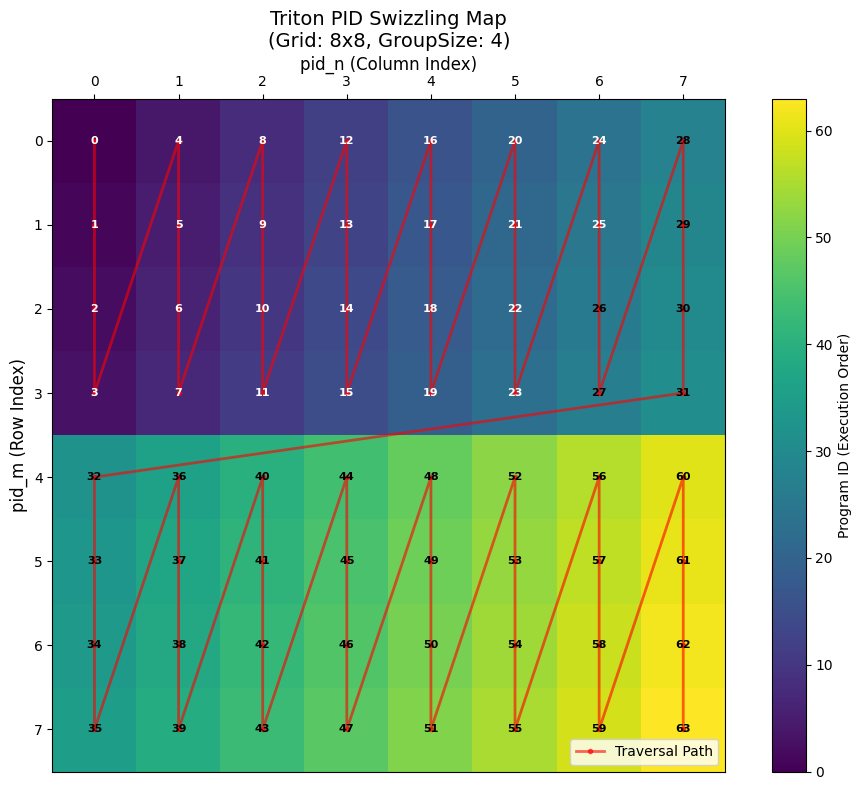

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def triton_swizzle_visualization(M, N, BLOCK_SIZE_M, BLOCK_SIZE_N, GROUP_SIZE_M):
    """
    模拟 OpenAI Triton 的 PID Swizzle 映射逻辑并绘图。
    """
    
    # 辅助函数：向上取整除法
    def cdiv(a, b):
        return (a + b - 1) // b

    # 1. 计算 Grid 的维度 (Grid Dimensions)
    num_pid_m = cdiv(M, BLOCK_SIZE_M)  # M轴方向有多少个块
    num_pid_n = cdiv(N, BLOCK_SIZE_N)  # N轴方向有多少个块
    total_programs = num_pid_m * num_pid_n

    print(f"Grid Size: {num_pid_m} (Rows) x {num_pid_n} (Cols)")
    print(f"Total Programs (PIDs): {total_programs}")
    print(f"Group Size M: {GROUP_SIZE_M}")

    # 用于存储坐标和顺序
    coords = [] 
    
    # 2. 遍历所有 PID，应用 Triton 的逻辑
    for pid in range(total_programs):
        # --- 以下完全照搬 Triton 的逻辑 ---
        num_pid_in_group = GROUP_SIZE_M * num_pid_n
        group_id = pid // num_pid_in_group
        first_pid_m = group_id * GROUP_SIZE_M
        group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
        
        pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
        pid_n = (pid % num_pid_in_group) // group_size_m
        # -------------------------------
        
        coords.append((pid_n, pid_m, pid)) # 存为 (x, y, order)

    # 3. 数据准备绘图
    coords = np.array(coords)
    x_vals = coords[:, 0] # pid_n (列)
    y_vals = coords[:, 1] # pid_m (行)
    pid_vals = coords[:, 2] # 执行顺序

    # 4. 绘制可视化图表
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # 绘制背景网格
    # 注意：imshow 的原点默认在左上角，这里我们要模拟矩阵布局
    grid_map = np.full((num_pid_m, num_pid_n), -1)
    for x, y, p in coords:
        grid_map[y, x] = p

    # 使用热力图显示顺序 (颜色越深/亮代表 PID 越大)
    plt.imshow(grid_map, cmap='viridis', origin='upper', aspect='equal')
    plt.colorbar(label='Program ID (Execution Order)')

    # 绘制路径连线 (从 pid=0 到 pid=max)
    # 这展示了 Kernel 是如何在 Grid 中"游走"的
    plt.plot(x_vals, y_vals, color='red', alpha=0.6, linewidth=2, marker='o', markersize=3, label='Traversal Path')

    # 在每个格子上标注 PID 数字
    for x, y, p in coords:
        # 文字颜色根据背景深浅自动调整（简单处理：前一半白，后一半黑，或者固定）
        text_color = 'white' if p < total_programs * 0.4 else 'black' 
        plt.text(x, y, str(p), ha='center', va='center', fontsize=8, color=text_color, fontweight='bold')

    # 设置轴标签和标题
    plt.title(f'Triton PID Swizzling Map\n(Grid: {num_pid_m}x{num_pid_n}, GroupSize: {GROUP_SIZE_M})', fontsize=14)
    plt.xlabel('pid_n (Column Index)', fontsize=12)
    plt.ylabel('pid_m (Row Index)', fontsize=12)
    
    # 设置刻度
    plt.xticks(np.arange(num_pid_n))
    plt.yticks(np.arange(num_pid_m))
    
    # 为了让原本的 (0,0) 在左上角，Matplotlib 默认行为即符合矩阵视角
    # 但我们可以在顶部显示 X 轴方便阅读
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.show()

# --- 配置参数 ---
# 假设我们要计算一个矩阵乘法
M_DIM = 1024
N_DIM = 1024
BLOCK_M = 128
BLOCK_N = 128
# GROUP_SIZE_M 控制 Swizzle 的行数跨度
GROUP_SIZE = 4 

# 运行可视化
triton_swizzle_visualization(M_DIM, N_DIM, BLOCK_M, BLOCK_N, GROUP_SIZE)

In [18]:
import torch
k = 4
n = 6

stride0 = n 
stride1 = 1

(torch.arange(k) * stride0 )[:, None] + (torch.arange(n) * stride1)[None, :]


tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23]])

In [21]:
# stride0 = 1
# stride1 = n

(torch.arange(k) * stride0 )[None, :]+ (torch.arange(n) * stride1 )[:, None]

# torch.arange(k)[:, None] * stride1 + torch.arange(n)[None, :] * stride0

tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]])